c:\Users\nayeon\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ROOT: c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lithodata
K_LIST: [60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
MetalSet N: 16472 | StdMetal N_B: 271
X_all: (16472, 65536)
PCA fit_dim=512, selected PCA_DIM=363 (AUTO=True, target=0.92)
cumulative explained variance @ PCA_DIM=363: 0.9200


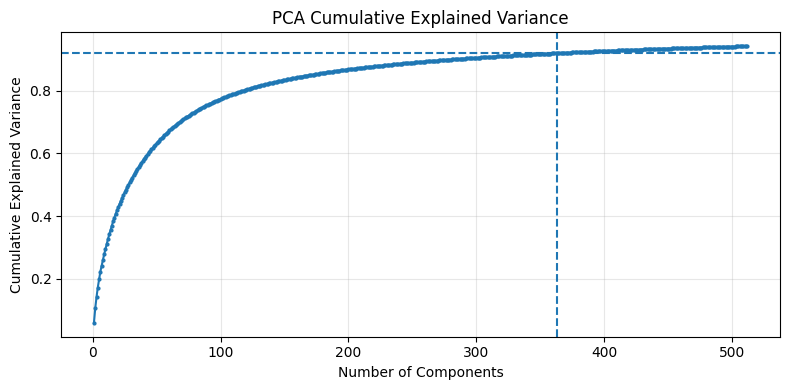

c:\Users\nayeon\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Z_umap_all: (16472, 15)

[K sweep results]
  K  silhouette     inertia  min_cluster_size  zero_alloc_ratio  alloc_deficit
 60    0.435820 9653.580078                 7          0.150000              0
 80    0.460998 6439.458984                 7          0.112500              0
100    0.494016 4413.479004                 7          0.080000              0
120    0.501455 3423.865967                 7          0.083333              0
140    0.519085 2785.088867                 7          0.085714              0
160    0.519047 2299.256592                 7          0.075000              0
180    0.524431 1916.685791                 7          0.083333              0
200    0.530936 1638.552002                 7          0.095000              0
220    0.537459 1400.149048                 7          0.100000              0
240    0.547489 1220.761719                 7          0.133333              0
260    0.546676 1090.356812                 7          0.153846              0
280    0.

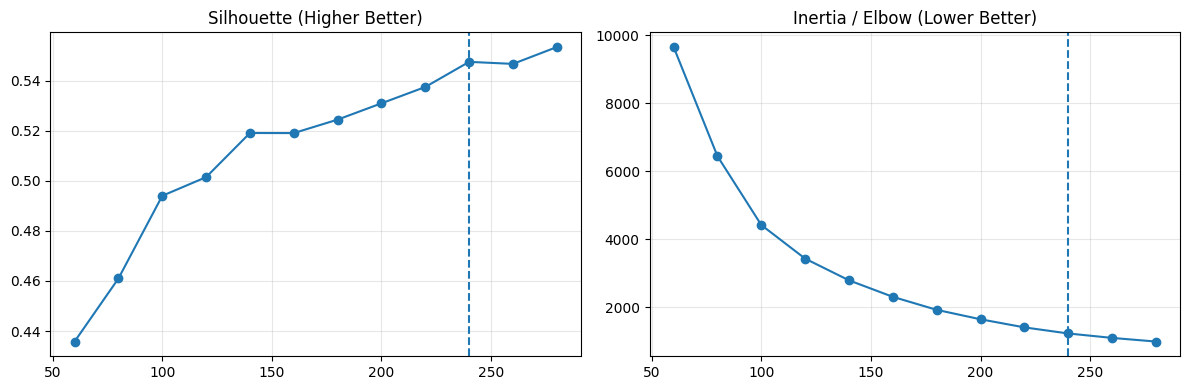


[Final sampling]
bestK: 240 | chosen: 271 | alloc_deficit: 0
zero_alloc_ratio: 0.13333333333333333


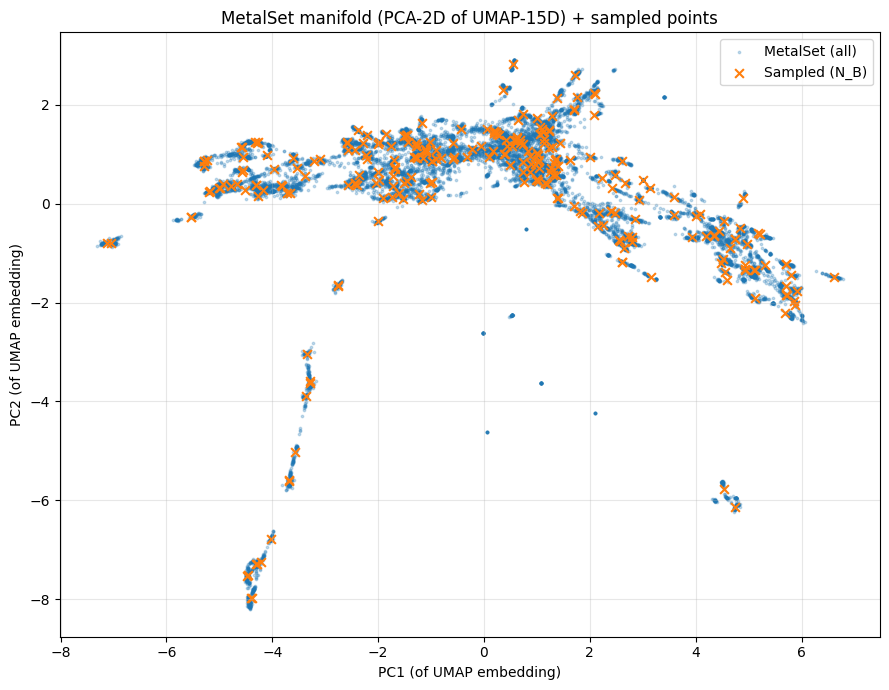


[Success] Manifest saved to: c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lithodata\manifest_MetalSet_rep271_PCA_UMAP_KMeans.csv
bestK=240, saved_rows=271, target_N_B=271


In [1]:
# ============================================================
# ONE-CELL (CLEAN / SIMPLE VERSION): FULL-fit (MetalSet ALL)
#   Goal: MetalSet(16k) -> sample N_B(≈271) while preserving diversity
#
#   Pipeline (standard & explainable):
#   1) Preprocess (binarize + downsample + flatten)
#   2) PCA (auto choose dim by cumulative explained variance)
#   3) UMAP (nonlinear manifold embedding)  [FULL-FIT]
#   4) KMeans sweep (Silhouette + Inertia only) -> choose K
#   5) Stratified sampling:
#        - allocate samples proportionally to cluster sizes
#        - pick nearest-to-centroid (prototype) within each cluster
#   6) Visualize: PCA EV, K metrics, UMAP-2D view + sampled red X
#   7) Save manifest in your legacy format/name
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

try:
    import umap
except ImportError:
    raise ImportError("umap-learn이 없습니다. 먼저 설치하세요: pip install umap-learn")

# ---------------------------
# 0) Config
# ---------------------------
SEED = 42
rng = np.random.default_rng(SEED)

ROOT = Path(r"c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lithodata")
SET_A = "MetalSet"
SET_B = "StdMetal"
MODS_STAGE = ["target"]
EXT = ".png"

DS_SIZE = 256
BIN_THR_TARGET = 0.5

# PCA
AUTO_PCA_DIM = True
PCA_VAR_TARGET = 0.92
PCA_DIM_FALLBACK = 200
PCA_MAX_DIM = 512
PCA_SVD_SOLVER = "randomized"

# UMAP (FULL-FIT)
UMAP_DIM = 15
UMAP_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1

# K sweep (simple)
K_LIST = list(range(60, 281, 20))     # coarse only
DEFAULT_N_B = 271

# K choice: simplest rule
#   "choose smallest K among top-M silhouette" (stable + interpretable)
TOP_M = 3

print("ROOT:", ROOT)
print("K_LIST:", K_LIST)

# ---------------------------
# 1) Utilities
# ---------------------------
def load_gray(path: Path) -> np.ndarray:
    img = Image.open(path).convert("L")
    arr = np.asarray(img, dtype=np.float32)
    if arr.max() > 1.0:
        arr /= 255.0
    return arr

def downsample_nearest(bin_img: np.ndarray, size=256) -> np.ndarray:
    pil = Image.fromarray((bin_img * 255).astype(np.uint8))
    pil = pil.resize((size, size), resample=Image.NEAREST)
    return (np.asarray(pil) > 0).astype(np.uint8)

def binarize_fixed(x: np.ndarray, thr=0.5, auto_invert=True) -> np.ndarray:
    b = (x >= thr).astype(np.uint8)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b

def list_ids(set_dir: Path, mod: str) -> set:
    folder = set_dir / mod
    paths = list(folder.rglob(f"*{EXT}"))
    return {p.stem for p in paths}

def build_manifest(set_name: str, mods) -> pd.DataFrame:
    set_dir = ROOT / set_name
    if not set_dir.exists():
        raise RuntimeError(f"경로 없음: {set_dir}")
    id_sets = {m: list_ids(set_dir, m) for m in mods}
    common = set.intersection(*[id_sets[m] for m in mods])
    if len(common) == 0:
        raise RuntimeError(f"{set_name}: {mods} stem 교집합이 0입니다. 파일명 규칙 확인 필요.")
    rows = []
    for bid in sorted(common):
        row = {"set": set_name, "base_id": bid}
        for m in mods:
            row[m] = str(set_dir / m / f"{bid}{EXT}")
        rows.append(row)
    return pd.DataFrame(rows)

def embed_flat_target(path_str: str, thr=BIN_THR_TARGET, size=DS_SIZE) -> np.ndarray:
    x = load_gray(Path(path_str))
    b = binarize_fixed(x, thr, auto_invert=True)
    b = downsample_nearest(b, size=size)
    return b.reshape(-1).astype(np.float32)

def alloc_proportional(counts: np.ndarray, total_pick: int) -> dict:
    counts = counts.astype(int)
    N = counts.sum()
    weights = counts / max(N, 1)
    raw = weights * total_pick
    alloc = np.floor(raw).astype(int)

    rem = total_pick - alloc.sum()
    frac = raw - alloc
    order = np.argsort(-frac)
    if rem > 0:
        alloc[order[:rem]] += 1

    # cap by cluster size
    alloc_cap = np.minimum(alloc, counts)

    # fill deficit if any
    deficit = total_pick - alloc_cap.sum()
    if deficit > 0:
        capacity = counts - alloc_cap
        refill_order = np.argsort(-capacity)
        for k in refill_order:
            if deficit <= 0:
                break
            if capacity[k] <= 0:
                continue
            take = min(capacity[k], deficit)
            alloc_cap[k] += take
            deficit -= take

    return {
        "alloc": alloc_cap,
        "zero_alloc_clusters": int(np.sum(alloc_cap == 0)),
        "deficit": int(deficit)
    }

def pick_nearest_to_centroid(
    Z: np.ndarray,
    labels: np.ndarray,
    centers: np.ndarray,
    alloc: np.ndarray
) -> np.ndarray:
    """Standard prototype sampling: pick closest-to-centroid points per cluster."""
    chosen = []
    K = len(alloc)
    for k in range(K):
        a = int(alloc[k])
        if a <= 0:
            continue
        idx = np.where(labels == k)[0]
        if len(idx) == 0:
            continue
        dif = Z[idx] - centers[k]
        d2 = np.sum(dif * dif, axis=1)
        order = np.argsort(d2)  # closest first
        chosen.extend(idx[order[:min(a, len(idx))]].tolist())
    return np.array(chosen, dtype=np.int64)

# ---------------------------
# 2) Load & Feature
# ---------------------------
man_A = build_manifest(SET_A, MODS_STAGE)
try:
    N_B = len(build_manifest(SET_B, MODS_STAGE))
except Exception:
    N_B = DEFAULT_N_B

X_all = np.stack([embed_flat_target(p) for p in man_A["target"].values])  # (N, 65536)

print("MetalSet N:", len(man_A), "| StdMetal N_B:", int(N_B))
print("X_all:", X_all.shape)

# ---------------------------
# 3) PCA fit + explained variance + auto PCA_DIM
# ---------------------------
n_samples, n_features = X_all.shape
pca_fit_dim = int(min(PCA_MAX_DIM, n_samples - 1, n_features))
if pca_fit_dim < 2:
    raise RuntimeError("PCA fit_dim이 너무 작습니다. 데이터 크기를 확인하세요.")

pca_full = PCA(n_components=pca_fit_dim, random_state=SEED, svd_solver=PCA_SVD_SOLVER)
Z_pca_full = pca_full.fit_transform(X_all)

evr = pca_full.explained_variance_ratio_
cev = np.cumsum(evr)

if AUTO_PCA_DIM:
    pca_dim = int(np.searchsorted(cev, PCA_VAR_TARGET) + 1)
    pca_dim = max(2, min(pca_dim, pca_fit_dim))
else:
    pca_dim = int(min(PCA_DIM_FALLBACK, pca_fit_dim))

print(f"PCA fit_dim={pca_fit_dim}, selected PCA_DIM={pca_dim} (AUTO={AUTO_PCA_DIM}, target={PCA_VAR_TARGET})")
print(f"cumulative explained variance @ PCA_DIM={pca_dim}: {cev[pca_dim-1]:.4f}")

Z_pca_all = Z_pca_full[:, :pca_dim].astype(np.float32)

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(cev)+1), cev, marker='o', markersize=2)
plt.axhline(PCA_VAR_TARGET, linestyle='--')
plt.axvline(pca_dim, linestyle='--')
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------
# 4) UMAP fit (FULL-FIT)
# ---------------------------
um = umap.UMAP(
    n_components=UMAP_DIM,
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    metric="euclidean",
    random_state=SEED
)
Z_umap_all = um.fit_transform(Z_pca_all).astype(np.float32)
print("Z_umap_all:", Z_umap_all.shape)

# ---------------------------
# 5) K sweep (Silhouette + Inertia only)
# ---------------------------
rows = []
for K in K_LIST:
    km = KMeans(n_clusters=K, random_state=SEED, n_init="auto")
    labels = km.fit_predict(Z_umap_all)
    sil = float(silhouette_score(Z_umap_all, labels)) if K > 1 else np.nan
    inertia = float(km.inertia_)

    # (optional) sanity stats only
    counts = np.bincount(labels, minlength=K)
    alloc_info = alloc_proportional(counts, int(N_B))

    rows.append({
        "K": int(K),
        "silhouette": sil,
        "inertia": inertia,
        "min_cluster_size": int(counts.min()),
        "zero_alloc_ratio": float(alloc_info["zero_alloc_clusters"] / K),
        "alloc_deficit": int(alloc_info["deficit"])
    })

df = pd.DataFrame(rows).sort_values("K").reset_index(drop=True)

print("\n[K sweep results]")
print(df[["K","silhouette","inertia","min_cluster_size","zero_alloc_ratio","alloc_deficit"]].to_string(index=False))

# ---------------------------
# 6) Choose K (simple rule)
#   - take TOP_M by silhouette
#   - among them, pick the smallest K (interpretability + less fragmentation)
# ---------------------------
df_ok = df[df["alloc_deficit"] == 0].copy()
if len(df_ok) == 0:
    df_ok = df.copy()

top = df_ok.sort_values("silhouette", ascending=False).head(TOP_M).copy()
top = top.sort_values("K").reset_index(drop=True)
bestK = int(top.loc[0, "K"])

print(f"\n>>> Suggested bestK (simple) = {bestK}")
print("[Top candidates by silhouette]")
print(top[["K","silhouette","inertia","min_cluster_size","zero_alloc_ratio"]].to_string(index=False))

# ---------------------------
# 7) Plot K metrics
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(df["K"], df["silhouette"], marker='o')
axes[0].axvline(bestK, linestyle='--')
axes[0].set_title("Silhouette (Higher Better)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(df["K"], df["inertia"], marker='o')
axes[1].axvline(bestK, linestyle='--')
axes[1].set_title("Inertia / Elbow (Lower Better)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---------------------------
# 8) Final clustering @ bestK + proportional stratified sampling (prototype)
# ---------------------------
km_final = KMeans(n_clusters=bestK, random_state=SEED, n_init="auto")
labels_final = km_final.fit_predict(Z_umap_all)

counts_final = np.bincount(labels_final, minlength=bestK)
alloc_final = alloc_proportional(counts_final, int(N_B))

chosen_final = pick_nearest_to_centroid(
    Z_umap_all, labels_final, km_final.cluster_centers_.astype(np.float32),
    alloc_final["alloc"]
)

print("\n[Final sampling]")
print("bestK:", bestK, "| chosen:", len(chosen_final), "| alloc_deficit:", alloc_final["deficit"])
print("zero_alloc_ratio:", float(np.sum(alloc_final["alloc"] == 0) / bestK))

# ---------------------------
# 9) Visualize manifold (2D) + sampled points as red X
#   - We already have UMAP in 15D; project to 2D using PCA for stable visualization
# ---------------------------
pca2 = PCA(n_components=2, random_state=SEED)
Z2 = pca2.fit_transform(Z_umap_all)

sample_mask = np.zeros(len(Z2), dtype=bool)
sample_mask[chosen_final] = True

plt.figure(figsize=(9, 7))
plt.scatter(Z2[~sample_mask, 0], Z2[~sample_mask, 1], s=3, alpha=0.25, label="MetalSet (all)")
plt.scatter(Z2[sample_mask, 0], Z2[sample_mask, 1], s=40, marker='x', linewidths=1.5, label="Sampled (N_B)")
plt.title("MetalSet manifold (PCA-2D of UMAP-15D) + sampled points")
plt.xlabel("PC1 (of UMAP embedding)")
plt.ylabel("PC2 (of UMAP embedding)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# 10) Save (legacy format/name)
# =============================================================================
chosen_indices = chosen_final.copy()
man_A_s = man_A.iloc[chosen_indices].reset_index(drop=True)
man_A_s["cluster"] = labels_final[chosen_indices]

save_path = ROOT / "manifest_MetalSet_rep271_PCA_UMAP_KMeans.csv"
man_A_s.to_csv(save_path, index=False)

print(f"\n[Success] Manifest saved to: {save_path}")
print(f"bestK={bestK}, saved_rows={len(man_A_s)}, target_N_B={int(N_B)}")
